# Erdos Institute Fall 2025  
## Exploratory Data Analysis: Possible features to include in final analysis for Patient Readmission Risk Project


Data is from ~ 22,000 synthetic patients generated by Shivani Chowdhry using the Synthea data generator, which creates synthetic electronic health records. Modelling aim is to use EHR features to predict hospital readmission rate after an inpatient encounter. 

The "patients" file includes the base patient data.
The "encounters" file includes all hospital encounters for those patients. 

The additional file analyzed here is "immunizations.csv"

The purpose of this EDA is to identify whether the "immunizations" file contains any features that warrant possible inclusion in a predictive model.

In [ ]:
# Basic setup
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)
from sklearn.calibration import CalibrationDisplay

# Set the base path to CSV files
path = "../Erdos_2025_project/"

# Load csv tables for patient and immunization data
patients = pd.read_csv(path + "patients.csv")
encounters = pd.read_csv(path + "encounters.csv")
immunizations = pd.read_csv(path + "immunizations.csv")

# Print file information
print("Patients:", patients.shape)
print("Encounters:", encounters.shape)
print("Immunizations:", immunizations.shape)



Patients: (22025, 28)
Encounters: (1320125, 15)
Medications: (1133505, 13)
Immunizations: (316669, 6)


Shivani wrote the following code to create a "readmission" metric for the encounters data. I have reused it here (version 10/26/2025)

In [2]:
# Number of unique patients
patients['Id'].nunique()

# Number of encounters per patient (first 5)
enc_per_patient = encounters.groupby('PATIENT').size().head()
print(enc_per_patient)

# Check a few columns
print(patients.columns)
print(encounters.columns)
print(immunizations.columns)

PATIENT
00010e8f-590e-3608-5307-0c075d7b83b6     27
00037657-224c-8a27-8e00-252779d41cc3     36
0004e2d2-969c-2b8e-b5c3-b1cc51eac06a     72
00070edc-4a3d-6dcb-de91-39d828ea23c5    544
00097b68-2bce-3e49-4b50-c28f44deed0b    302
dtype: int64
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'BASE_COST'], dtype='object')


In [3]:
# Filter for inpatient encounters (hospital admissions/discharges):
inpatient = encounters[encounters['ENCOUNTERCLASS'] == 'inpatient'].copy()


In [4]:
# Convert START and STOP times to datetime:
inpatient['START'] = pd.to_datetime(inpatient['START'])
inpatient['STOP']  = pd.to_datetime(inpatient['STOP'])

In [5]:
# Create the “readmission within 30 days” label
inpatient = inpatient.sort_values(['PATIENT', 'START'])
inpatient['NEXT_START'] = inpatient.groupby('PATIENT')['START'].shift(-1)
inpatient['READMIT_30D'] = (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days <= 30
) & (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days > 0
)
inpatient['READMIT_30D'] = inpatient['READMIT_30D'].fillna(False).astype(int)

In [6]:
# Engineering features
# Age
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])
patients['AGE'] = (pd.Timestamp('today') - patients['BIRTHDATE']).dt.days / 365

# Merge patient info into encounters
data = inpatient.merge(patients[['Id','AGE','GENDER','RACE','ETHNICITY']],
                       left_on='PATIENT', right_on='Id', how='left')

# Example feature set
X = data[['AGE', 'GENDER', 'RACE', 'ETHNICITY']].copy()
y = data['READMIT_30D']

# Convert categorical features to dummies
X = pd.get_dummies(X, drop_first=True)

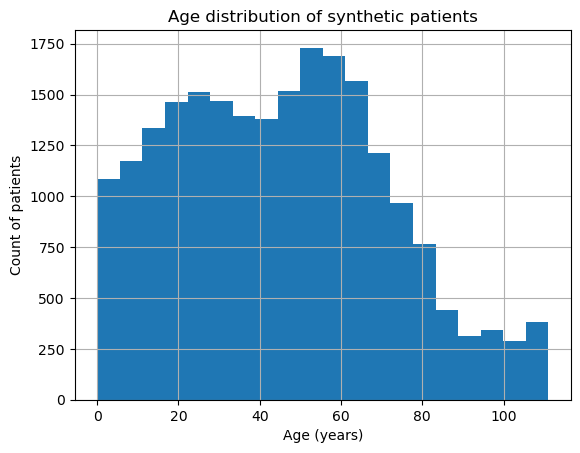

In [7]:
# Data plotting

# Convert birthdate to age in years
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])
patients['AGE'] = (pd.Timestamp('today') - patients['BIRTHDATE']).dt.days / 365

patients['AGE'].hist(bins=20)
plt.xlabel("Age (years)")
plt.ylabel("Count of patients")
plt.title("Age distribution of synthetic patients")
plt.show()

Next, exploring the "Immunizations" data:

In [8]:
# Immunizations data

# How many rows and columns?
print("Immunizations:", immunizations.shape)

# What are the columns?
print(immunizations.columns)

# Cast the "CODE" column as a string:
immunizations['CODE'] = immunizations['CODE'].astype(str)

# How many total unique immunization types are in the dataset?
print("Unique Immunizations, Code:", immunizations['CODE'].nunique())
print("Unique Immunizations, Description:", immunizations['DESCRIPTION'].nunique())

# Print first five rows
immunizations.head()

Immunizations: (316669, 6)
Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'BASE_COST'], dtype='object')
Unique Immunizations, Code: 22
Unique Immunizations, Description: 25


,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,BASE_COST
0,2024-08-12T19:52:00Z,f173c55d-26fa-40a7-4d3d-a0a77af219ec,f173c55d-26fa-40a7-b077-8cc08109602a,8,Hep B adolescent or pediatric,136.0
1,2024-09-16T19:52:00Z,f173c55d-26fa-40a7-4d3d-a0a77af219ec,f173c55d-26fa-40a7-5739-e1010ba4aa6f,8,Hep B adolescent or pediatric,136.0
2,2024-11-18T19:52:00Z,f173c55d-26fa-40a7-4d3d-a0a77af219ec,f173c55d-26fa-40a7-a618-1b0f619c9469,49,Hib (PRP-OMP),136.0
3,2024-11-18T19:52:00Z,f173c55d-26fa-40a7-4d3d-a0a77af219ec,f173c55d-26fa-40a7-a618-1b0f619c9469,119,rotavirus monovalent,136.0
4,2024-11-18T19:52:00Z,f173c55d-26fa-40a7-4d3d-a0a77af219ec,f173c55d-26fa-40a7-a618-1b0f619c9469,10,IPV,136.0


In [9]:
# The Code and Description don't quite match up. Get and print the unique values in the "DESCRIPTION" column

immunizations['DESCRIPTION'].unique()

array(['Hep B  adolescent or pediatric', 'Hib (PRP-OMP)',
       'rotavirus  monovalent', 'IPV', 'DTaP',
       'Pneumococcal conjugate PCV 13',
       'Influenza  seasonal  injectable  preservative free',
       'zoster vaccine  live',
       'Td (adult)  5 Lf tetanus toxoid  preservative free  adsorbed',
       'Hep A  adult', 'COVID-19  mRNA  LNP-S  PF  30 mcg/0.3 mL dose',
       'Tdap', 'HPV  quadrivalent', 'meningococcal MCV4P', 'Hep B  adult',
       'COVID-19  mRNA  LNP-S  PF  100 mcg/0.5mL dose or 50 mcg/0.25mL dose',
       'Hep A  ped/adol  2 dose', 'varicella', 'MMR',
       'pneumococcal polysaccharide vaccine  23 valent',
       'COVID-19 vaccine  vector-nr  rS-Ad26  PF  0.5 mL',
       'tetanus toxoid  reduced diphtheria toxoid  and acellular pertussis vaccine  adsorbed',
       'meningococcal polysaccharide (groups A  C  Y and W-135) diphtheria toxoid conjugate vaccine (MCV4P)',
       'pneumococcal conjugate vaccine  13 valent',
       'zoster vaccine recombinant'], dt

In [10]:
# Find out which Codes are matching to more than one Description:
duplicates = (
    immunizations.groupby('CODE')['DESCRIPTION']
    .nunique()            # count unique Descriptions per Code
    .reset_index(name="unique_descriptions")
)

# Filter for Code values that map to more than one Description
violations = duplicates[duplicates["unique_descriptions"] > 1]

print(violations)


  CODE  unique_descriptions
2  114                    2
3  115                    2
6  133                    2


In [11]:
# Which Descriptions are used more than once?
problem_mappings = (
    immunizations.groupby("CODE")["DESCRIPTION"]
    .agg(lambda x: list(set(x)))
    .reset_index()
)

problem_mappings = problem_mappings[problem_mappings["DESCRIPTION"].apply(len) > 1]

print(problem_mappings)
print(problem_mappings.loc[6, 'DESCRIPTION'])

  CODE                                        DESCRIPTION
2  114  [meningococcal polysaccharide (groups A  C  Y ...
3  115  [Tdap, tetanus toxoid  reduced diphtheria toxo...
6  133  [Pneumococcal conjugate PCV 13, pneumococcal c...
['Pneumococcal conjugate PCV 13', 'pneumococcal conjugate vaccine  13 valent']


This explains the issue. In this case, for our analysis "Code" should be used, as these three are essentially duplicates of the same vaccines 

Next, look at the number of instances of each vaccine:

   Code  row_count
0   140     177154
1   113      16301
2   208      14515
3   207      11515
4    20      10581
5   133      10110
6    10       8882
7   114       7928
8    62       7595
9    49       6386
10    8       6330
11  121       6270
12   52       5569
13   43       4807
14    3       4461
15   21       4404
16   83       4238
17  119       4104
18  115       2560
19   33       2073
20  212        836
21  187         50


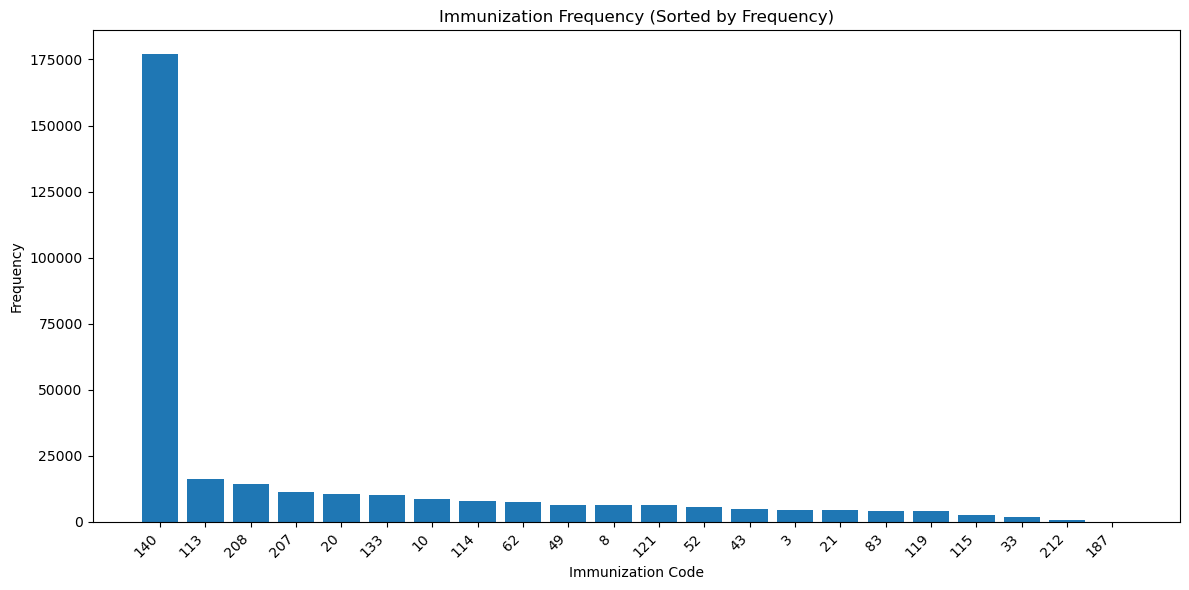

In [12]:
# Count how many rows correspond to each unique Code value
counts = immunizations["CODE"].value_counts().reset_index()

# Rename columns for clarity
counts.columns = ["Code", "row_count"]

print(counts)


#What is the discribution of the immunizations used?
frequency_counts = immunizations['CODE'].value_counts()

# Create a bar plot using the sorted frequencies
plt.figure(figsize=(12, 6))
plt.bar(frequency_counts.index, frequency_counts.values)
plt.xlabel('Immunization Code')
plt.ylabel('Frequency')
plt.title('Immunization Frequency (Sorted by Frequency)')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability if needed
plt.tight_layout()
plt.show()

What we can see is that the flu vaccine has a completely different data shape than the other vaccines. This is because the flu vaccine is annual and the same patients received the flu vaccine many, many, times. 
As per our meeting discussion, we decided to only include "seasonal" vaccines. This would theorhetically be flu (140), and the three Covid vaccines (207, 208, 212), as well as possibly pneumonia vaccines, although these tend to be administered far less often. Since Covid 19 did not exist before late 2019, we must be sure to include the date of the encounter as a feature in the model (otherwise, we will get weird signal because of the pandemic).  

If we want to model on this data, we need to set it up such that the only vaccines used for prediction are those that were administered prior to the encounter. I suggest that we only model on a vaccine received within 1 year of the enounter. For now, only the flu vaccine will be included.

In [ ]:

# --- Create metric: flu vaccine within 1 year of encounter
encounters = pd.read_csv(path + "encounters.csv")
immunizations = pd.read_csv(path + "immunizations.csv")

# --- Cast the "CODE" column as a string:
immunizations['CODE'] = immunizations['CODE'].astype(str)

# --- Rename encounter Id column to match immunizations encounter 
encounters.rename(columns={'Id':'ENCOUNTER'}, inplace=True)

# --- Convert date columns to datetime ---
encounters["START"] = pd.to_datetime(encounters["START"], utc=True)
immunizations["DATE"] = pd.to_datetime(immunizations["DATE"], utc=True)

# --- Filter immunizations for code 140 (Flu vaccine)---
immun_140 = immunizations[immunizations["CODE"] == "140"].copy()

# --- Merge encounter patient id with flu vaccine data ---
merged = encounters.merge(
    immun_140[["PATIENT", "DATE"]],
    on="PATIENT",
    how="left"
)

# --- Check if an immunization occurred within 1 year BEFORE or ON the encounter date ---
merged["within_1_year"] = (
    (merged["DATE"] <= merged["START"]) &
    (merged["DATE"] >= merged["START"] - pd.Timedelta(days=365))
)

# --- Collapse back to one row per encounter ---
encounters["fluvax_within_1_year"] = (
    merged.groupby("ENCOUNTER")["within_1_year"].any().reindex(encounters["ENCOUNTER"]).values
)

print(encounters.head)


<bound method NDFrame.head of                                     ENCOUNTER                     START  \
0        f173c55d-26fa-40a7-b077-8cc08109602a 2024-08-12 19:52:00+00:00   
1        f173c55d-26fa-40a7-5739-e1010ba4aa6f 2024-09-16 19:52:00+00:00   
2        f173c55d-26fa-40a7-a618-1b0f619c9469 2024-11-18 19:52:00+00:00   
3        f173c55d-26fa-40a7-ca3a-a615921a881a 2025-01-20 19:52:00+00:00   
4        f173c55d-26fa-40a7-be65-14cedc9bf4a4 2025-04-21 19:52:00+00:00   
...                                       ...                       ...   
1320120  c40cd53c-2e5d-a0ca-22d5-4ef7c61f8460 2025-08-01 20:00:17+00:00   
1320121  c40cd53c-2e5d-a0ca-d18b-3e29392a4b51 2025-08-08 20:00:17+00:00   
1320122  c40cd53c-2e5d-a0ca-d668-e41a0458a682 2025-08-22 20:00:17+00:00   
1320123  c40cd53c-2e5d-a0ca-06a8-c3b8af5fb47b 2025-10-03 20:00:17+00:00   
1320124  c40cd53c-2e5d-a0ca-1839-347280e91861 2025-10-10 20:00:17+00:00   

                         STOP                               PATIENT  

In [ ]:
# --- Check how many T's and F's are in the data for this metric:
fluvax_counts = encounters['fluvax_within_1_year'].value_counts()

print(fluvax_counts)

fluvax_within_1_year
True     1030718
False     289407
Name: count, dtype: int64


Now getting ready to model:

In [ ]:
# Merge encounters, patients, and flu vaccine metric

# --- Rename 'data' Id column to match immunizations 'encounter', and drop the redundant 'Id_y' column, which is identical to 'PATIENT' 
data.rename(columns={'Id_x':'ENCOUNTER'}, inplace=True)
data = data.drop('Id_y', axis=1)

# --- Merge the fluvax feature column into the inpatient dataset ---
data = data.merge(
    encounters[['ENCOUNTER', 'fluvax_within_1_year']],
    on='ENCOUNTER',
    how="left"
)


In [16]:
print(data.columns)

Index(['ENCOUNTER', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'PAYER', 'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION',
       'NEXT_START', 'READMIT_30D', 'AGE', 'GENDER', 'RACE', 'ETHNICITY',
       'fluvax_within_1_year'],
      dtype='object')


Examine the data:

In [ ]:
summary = pd.crosstab(data["fluvax_within_1_year"], data["READMIT_30D"])

summary.index.name = "Flu vaccine within 1 year"
summary.columns.name = "Readmitted within 30 days"

print(summary)

Readmitted within 30 days      0     1
Flu vaccine within 1 year             
False                       6450   260
True                       11498  3581


In [ ]:
# --- Define features and outcome ---
X = data[["fluvax_within_1_year"]].astype(int)
y = data["READMIT_30D"].astype(int)
groups = data["PATIENT"]  # will be employed for group-aware splitting

# --- Group-aware split to avoid data leakage (so patients will not appear in both sets) ---
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# --- Fit logistic regression ---
model = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)
model.fit(X_train, y_train)

# --- Predict and get probabilities ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- Evaluate performance ---
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# --- View model coefficients ---
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})
print("\nModel coefficients:\n", coef_df)

Accuracy: 0.448
ROC AUC: 0.654

Confusion Matrix:
 [[1917 3306]
 [  50  810]]

Classification Report:
               precision    recall  f1-score   support

           0      0.975     0.367     0.533      5223
           1      0.197     0.942     0.326       860

    accuracy                          0.448      6083
   macro avg      0.586     0.654     0.429      6083
weighted avg      0.865     0.448     0.504      6083


Model coefficients:
                 Feature  Coefficient
0  fluvax_within_1_year     1.979661


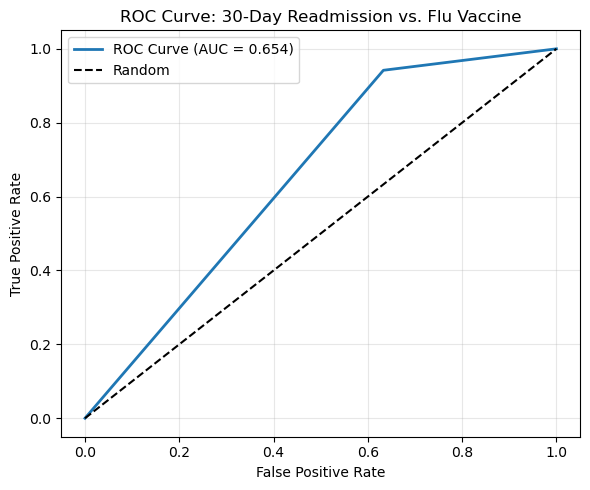

<Figure size 600x500 with 0 Axes>

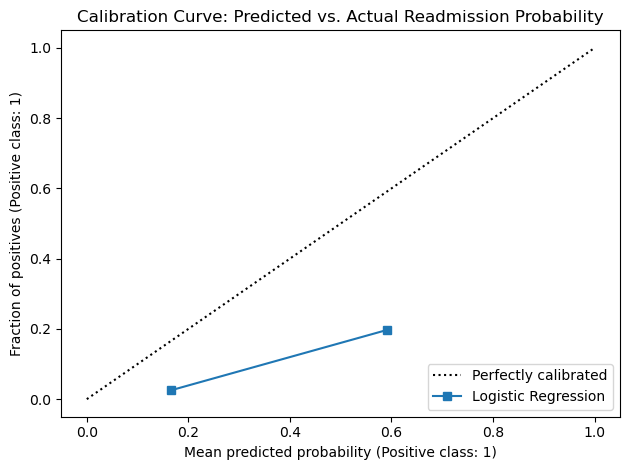

In [ ]:

# --- ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: 30-Day Readmission vs. Flu Vaccine")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# --- Calibration Curve

plt.figure(figsize=(6, 5))
CalibrationDisplay.from_estimator(
    model,
    X_test,
    y_test,
    n_bins=10,
    strategy='uniform',
    name="Logistic Regression"
)
plt.title("Calibration Curve: Predicted vs. Actual Readmission Probability")
plt.tight_layout()
plt.show()